In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Import thư viện PyTorch 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

#Các tham số cơ bản
STOCK_TICKER = "MSFT"
START_DATE = "2020-01-01"
END_DATE = "2025-01-01"
LOOK_BACK = 60 # Độ dài chuỗi 

#Các tham số cho mô hình & training
BATCH_SIZE = 32
HIDDEN_SIZE = 50 
NUM_LAYERS = 2   # Số tầng LSTM
DROPOUT_RATE = 0.2
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
PATIENCE = 10   

# Thiết lập Device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cpu


In [ ]:
# Tải dữ liệu 
print(f"Đang tải dữ liệu cho {STOCK_TICKER}...")
df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)

#  Trích xuất giá đóng cửa
price_data = df[['Close']].values
print(f"Dữ liệu gốc có shape: {price_data.shape}")

# Hiển thị 5 dòng đầu
print("\n5 dòng dữ liệu đầu:")
print(df.head())

Đang tải dữ liệu cho MSFT...


C:\Users\Nguyen Trung An\AppData\Local\Temp\ipykernel_27820\3580987742.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(STOCK_TICKER, start=START_DATE, end=END_DATE)
[*********************100%***********************]  1 of 1 completed

Dữ liệu gốc có shape: (1258, 1)

5 dòng dữ liệu đầu:
Price            Close        High         Low        Open    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2020-01-02  152.791153  152.895792  150.612777  151.040841  22622100
2020-01-03  150.888611  152.153786  150.355908  150.603245  21116200
2020-01-06  151.278610  151.345205  148.881435  149.423659  20813700
2020-01-07  149.899307  151.887434  149.651985  151.554502  21634100
2020-01-08  152.286926  152.962326  150.251234  151.183463  27746500


In [ ]:
# Tách tập Train / Validation / Test 
total_len = len(price_data)
train_split_idx = int(total_len * 0.7)
val_split_idx = int(total_len * 0.85)

raw_train = price_data[0:train_split_idx]
raw_val = price_data[train_split_idx:val_split_idx]
raw_test = price_data[val_split_idx:]

print(f"Kích thước tập Train thô: {len(raw_train)}")
print(f"Kích thước tập Val thô: {len(raw_val)}")
print(f"Kích thước tập Test thô: {len(raw_test)}")

#Chuẩn hóa dữ liệu 
data_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = data_scaler.fit_transform(raw_train)
scaled_val = data_scaler.transform(raw_val)
scaled_test = data_scaler.transform(raw_test)

Kích thước tập Train thô: 880
Kích thước tập Val thô: 189
Kích thước tập Test thô: 189


In [ ]:
def create_sequences(dataset, seq_length):
    """
    Tạo chuỗi X và y bằng cách sử dụng các phép toán mảng của NumPy 
    thay vì vòng lặp for.
    """
    n_samples = len(dataset) - seq_length
    
    # Tạo một mảng các chỉ số bắt đầu: [0, 1, 2, ..., n_samples-1]
    start_indices = np.arange(n_samples)
    
    # Tạo X: Dùng broadcasting để tạo một ma trận 2D các chỉ số
    # indices_X = 
    # [ [0, 1, ..., 59],  (cho seq_length=60)
    #   [1, 2, ..., 60],
    #   ... ]
    indices_X = start_indices[:, None] + np.arange(seq_length)
    
    # Tạo y: Lấy chỉ số của phần tử ngay sau mỗi chuỗi
    # indices_y = [60, 61, ..., n_samples+59]
    indices_y = start_indices + seq_length
    
    # Dùng "fancy indexing" của NumPy để trích xuất dữ liệu
    X = dataset[indices_X]
    y = dataset[indices_y]
    
    # Hàm này đã trả về np.array,
    return X, y


In [ ]:
# Tạo X_train, y_train
X_train, y_train = create_sequences(scaled_train, LOOK_BACK)

# Tạo X_val, y_val 
val_input_data = np.concatenate((scaled_train[-LOOK_BACK:], scaled_val))
X_val, y_val = create_sequences(val_input_data, LOOK_BACK)

# Tạo X_test, y_test
test_input_data = np.concatenate((scaled_val[-LOOK_BACK:], scaled_test))
X_test, y_test = create_sequences(test_input_data, LOOK_BACK)

print(f"Shape của X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape của X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Shape của X_test: {X_test.shape}, y_test: {y_test.shape}")

# Chuyển đổi sang PyTorch Tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_numpy = y_test # Giữ y_test (numpy) để đánh giá

Shape của X_train: (820, 60, 1), y_train: (820, 1)
Shape của X_val: (189, 60, 1), y_val: (189, 1)
Shape của X_test: (189, 60, 1), y_test: (189, 1)


In [ ]:
#  Định nghĩa Mô hình LSTM (Cú pháp khác, dùng Trạng thái ẩn h_n)
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, dropout=DROPOUT_RATE):
        super(LSTMModel, self).__init__()
        
        # Tầng LSTM vẫn giữ nguyên
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        self.dropout = nn.Dropout(dropout) 
        self.fc = nn.Linear(hidden_size, 1)

    # CÚ PHÁP KHÁC NẰM Ở ĐÂY 
    def forward(self, x):
        
        #    outputs: Toàn bộ chuỗi output (batch_size, seq_len, hidden_size)
        #    h_n: Trạng thái ẩn CUỐI CÙNG (num_layers, batch_size, hidden_size)
        #    c_n: Trạng thái ô CUỐI CÙNG (num_layers, batch_size, hidden_size)
        outputs, (h_n, c_n) = self.lstm(x)
        
        #chúng ta lấy trạng thái ẩn (h_n) 
        #    của tầng CUỐI CÙNG (h_n[-1]).
        #    Shape của h_n[-1] là (batch_size, hidden_size)
        out = h_n[-1] 
        
        # Các bước sau giữ nguyên
        out = self.dropout(out) 
        out = self.fc(out) 
        return out

print("Đã định nghĩa class LSTMModel(nn.Module) (Dùng cú pháp h_n)")

Đã định nghĩa class LSTMModel(nn.Module) (Dùng cú pháp h_n)


In [ ]:
# Tạo DataLoader 
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Đã tạo DataLoader với Batch Size: {BATCH_SIZE}")

# Khởi tạo mô hình, Hàm lỗi, Optimizer
model = LSTMModel().to(device)
criterion = nn.MSELoss() # Tương đương loss='mean_squared_error'
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # Tương đương optimizer='adam'

print("\nCấu trúc mô hình PyTorch:")
print(model)

Đã tạo DataLoader với Batch Size: 32

Cấu trúc mô hình PyTorch:
LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


In [ ]:
# Vòng lặp training 
print("Bắt đầu quá trình huấn luyện (luôn chạy 100 epochs)...")

# Vẫn giữ lại best_val_loss để lưu model tốt nhất
best_val_loss = float('inf') 
history = {'train_loss': [], 'val_loss': []}

for epoch in range(NUM_EPOCHS):
    model.train() # Đặt ở chế độ training
    epoch_train_loss = 0.0
    
    # Lặp qua các batch
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
    avg_train_loss = epoch_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)

    
    model.eval() # Đặt ở chế độ evaluation
    epoch_val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item()
            
    avg_val_loss = epoch_val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    
    # Vẫn so sánh để lưu model tốt nhất
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Lưu lại model tốt nhất
        torch.save(model.state_dict(), "best_model.pth") 
        print(f"   -> Val Loss cải thiện. Đã lưu model!")
    else:
        # Không làm gì cả, cứ tiếp tục chạy
        pass
    
    

print(f"\nHoàn tất huấn luyện (đã chạy đủ {NUM_EPOCHS} epochs).")
print(f"Model tốt nhất (với Val Loss: {best_val_loss:.6f}) đã được lưu tại 'best_model.pth'")

Bắt đầu quá trình huấn luyện (luôn chạy 100 epochs)...
Epoch [1/100] | Train Loss: 0.245364 | Val Loss: 0.136371
   -> Val Loss cải thiện. Đã lưu model!
Epoch [2/100] | Train Loss: 0.034942 | Val Loss: 0.147975
Epoch [3/100] | Train Loss: 0.023214 | Val Loss: 0.047587
   -> Val Loss cải thiện. Đã lưu model!
Epoch [4/100] | Train Loss: 0.010026 | Val Loss: 0.019792
   -> Val Loss cải thiện. Đã lưu model!
Epoch [5/100] | Train Loss: 0.007952 | Val Loss: 0.040249
Epoch [6/100] | Train Loss: 0.007095 | Val Loss: 0.018035
   -> Val Loss cải thiện. Đã lưu model!
Epoch [7/100] | Train Loss: 0.006982 | Val Loss: 0.014415
   -> Val Loss cải thiện. Đã lưu model!
Epoch [8/100] | Train Loss: 0.006275 | Val Loss: 0.017842
Epoch [9/100] | Train Loss: 0.006911 | Val Loss: 0.009431
   -> Val Loss cải thiện. Đã lưu model!
Epoch [10/100] | Train Loss: 0.005610 | Val Loss: 0.020697
Epoch [11/100] | Train Loss: 0.005923 | Val Loss: 0.012336
Epoch [12/100] | Train Loss: 0.004969 | Val Loss: 0.013904
Epoch 

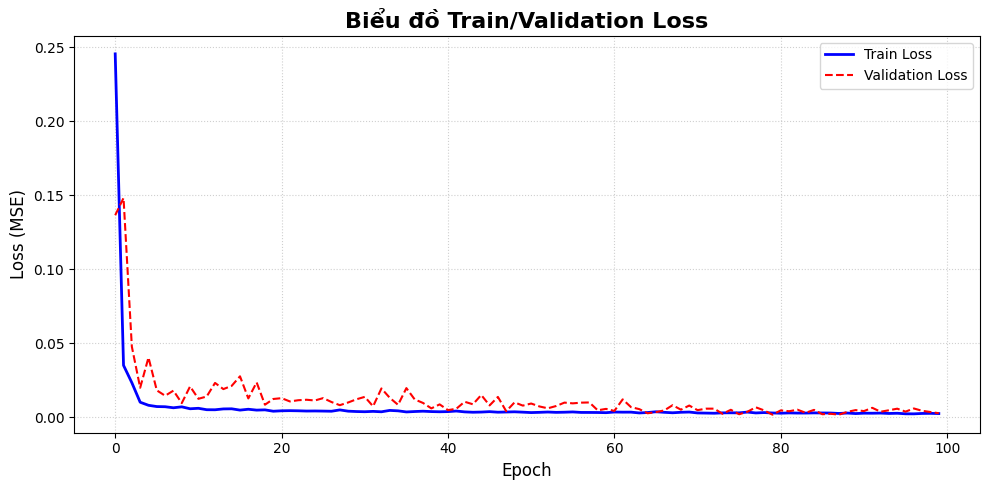

In [ ]:

# 1. Tạo Figure (toàn bộ khung hình) và Axes (vùng vẽ biểu đồ)
fig, ax = plt.subplots(figsize=(10, 5))

# 2. Sử dụng đối tượng Axes (ax) để vẽ
ax.plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
ax.plot(history['val_loss'], label='Validation Loss', color='red', linestyle='--')

# 3. Sử dụng đối tượng Axes để thiết lập các thuộc tính
ax.set_title('Biểu đồ Train/Validation Loss', fontsize=16, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss (MSE)', fontsize=12)

# 4. Thêm các yếu tố khác
ax.legend(loc='upper right', frameon=True)
ax.grid(True, linestyle=':', alpha=0.6)

# 5. Hiển thị biểu đồ
plt.tight_layout() # Tự động điều chỉnh khoảng cách
plt.show()

In [ ]:
print("Bắt đầu đánh giá trên tập Test...")

# Tải mô hình tốt nhất đã lưu
try:
    model.load_state_dict(torch.load("best_model.pth"))
    print("Đã tải model tốt nhất từ 'best_model.pth'")
except FileNotFoundError:
    print("Không tìm thấy file 'best_model.pth', sử dụng model cuối cùng.")

model.eval() # Đặt ở chế độ evaluation

# Thực hiện dự đoán 
with torch.no_grad():
    X_test_tensor_device = X_test_tensor.to(device)
    test_predictions_scaled = model(X_test_tensor_device)
    test_predictions_scaled_np = test_predictions_scaled.cpu().numpy()

# Chuyển đổi ngược (Inverse Transform)
test_predictions_raw = data_scaler.inverse_transform(test_predictions_scaled_np)
y_test_raw = data_scaler.inverse_transform(y_test_numpy) 

# Tính toán các chỉ số lỗi 
mae = mean_absolute_error(y_test_raw, test_predictions_raw)
rmse = np.sqrt(mean_squared_error(y_test_raw, test_predictions_raw))
r2 = r2_score(y_test_raw, test_predictions_raw)

print(f"\n--- Kết quả Đánh giá trên tập Test ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 Score): {r2:.4f}")

Bắt đầu đánh giá trên tập Test...
Đã tải model tốt nhất từ 'best_model.pth'

--- Kết quả Đánh giá trên tập Test ---
Mean Absolute Error (MAE): 15.57
Root Mean Squared Error (RMSE): 17.14
R-squared (R2 Score): -0.1993


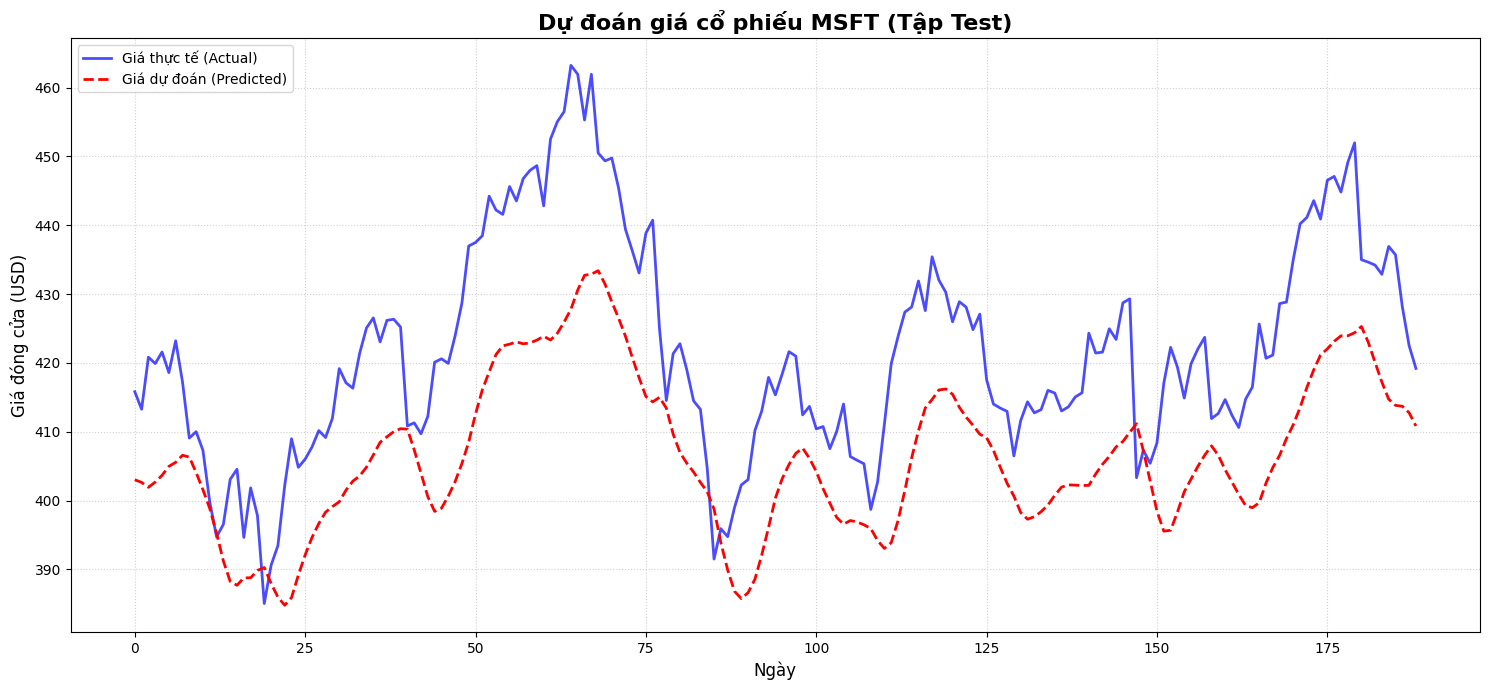

In [ ]:
# Trực quan hóa kết quả 
fig, ax = plt.subplots(figsize=(15, 7))

# Sử dụng ax để vẽ
ax.plot(y_test_raw, label='Giá thực tế (Actual)', color='blue', alpha=0.7, linewidth=2)
ax.plot(test_predictions_raw, label='Giá dự đoán (Predicted)', color='red', linestyle='--', linewidth=2)

# Sử dụng ax.set_ để đặt tiêu đề và nhãn
ax.set_title(f'Dự đoán giá cổ phiếu {STOCK_TICKER} (Tập Test)', fontsize=16, fontweight='bold')
ax.set_xlabel('Ngày', fontsize=12)
ax.set_ylabel('Giá đóng cửa (USD)', fontsize=12)

# Thêm chú thích và lưới
ax.legend(loc='upper left')
ax.grid(True, linestyle=':', alpha=0.6)

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()